In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from yfinance_loader import download_tickers
import timeit

%matplotlib inline

In [2]:
tickers = pd.read_csv('ticker_lists/ndx.csv', header=None)
tickers = tickers[0].to_list()

In [69]:
# Timing 
i = 1
setup_code = 'from yfinance_loader import download_tickers'
run = """download_tickers(['XACTC25.CO'], False, return_only=['Adj Close','Volume'])"""
timeit.timeit(run, setup=setup_code, number=i)/i

0.011632498594999562

In [78]:
tickers = ['GMAB.CO']
stocks = download_tickers(tickers, False, return_only=['Adj Close'])

In [79]:
print(stocks)

Stock ticker      GMAB.CO
Data type       Adj Close
Date                     
2012-06-18      45.599998
2012-06-19      50.049999
2012-06-20      48.799999
2012-06-21      51.450001
2012-06-22      53.299999
...                   ...
2020-09-03    2263.000000
2020-09-04    2178.000000
2020-09-07    2260.000000
2020-09-08    2204.000000
2020-09-09    2264.000000

[2051 rows x 1 columns]


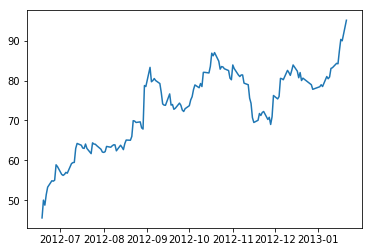

In [80]:
plt.plot(stocks.iloc[:-1900, 0])